# Audio-based Depression Detection Model

In [1]:

from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

from models.audio_rnn import AudioRNN
from preprocessing.loader_audio import AudioLoader
from preprocessing.loader_results import ResultsLoader
from training.trainer_audio_rnn import AudioRNNTrainer

# Constants
RANDOM_STATE = 42
DATA_PERCENTAGE = 0.05  # Percentage of total data to use
BATCH_SIZE = 32
N_EPOCHS = 50
FIGURE_SIZE = (15, 8)

# Hyperparameter grid for model tuning
PARAM_GRID = {
    'hidden_size': [32, 64],
    'num_layers': [1],
    'dropout': [0.3, 0.4],
    'learning_rate': [0.001, 0.0005],
}

# Device configuration
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: mps


## Data Preparation

In [2]:
def load_data(percentage: float = DATA_PERCENTAGE, random_state: int = RANDOM_STATE) -> Tuple[
    pd.DataFrame, pd.DataFrame]:
    #Load and prepare the audio data and depression labels.
    # Initialize loaders
    results_loader = ResultsLoader()
    audio_loader = AudioLoader()

    # Load data
    df_result = results_loader.get_data(percentage=percentage, random_state=random_state)
    df_audio = audio_loader.get_data(
        percentage=percentage,
        random_state=random_state,
        ds_freq="10s",
        rw_size="10s"
    )

    return df_audio, df_result


# Load the data
df_audio, df_result = load_data()

# Display data 
print("Audio Features:")
display(df_audio.head())
print("\nReslutls:")
display(df_result.head())

Audio Features:


AUDIO_AMPLITUDE  FORMANT_F1  FORMANT_F2  FORMANT_F3  \
ID  TIMESTAMP                                                              
322 0 days 00:00:00        -0.000019  778.876818  1719.71932  2625.82470   
    0 days 00:00:10        -0.000027  813.887130  1756.83828  2639.09310   
    0 days 00:00:20         0.000029  659.160090  1613.90003  2543.96407   
    0 days 00:00:30        -0.000073  930.487398  1735.20519  2605.24830   
    0 days 00:00:40        -0.000023  663.727100  1600.62728  2537.41398   

                     FORMANT_F4  FORMANT_F5  COVAREP_F0  COVAREP_VUV  \
ID  TIMESTAMP                                                          
322 0 days 00:00:00   3511.3775   4414.9879    169.4775        0.200   
    0 days 00:00:10   3504.5215   4409.6285    173.8530        0.156   
    0 days 00:00:20   3468.3981   4370.4945    170.7145        0.335   
    0 days 00:00:30   3466.8205   4341.1698    171.8255        0.026   
    0 days 00:00:40   3470.6450   4387.6753    169.0620        0.257   

                     COVAREP_NAQ  COVAREP_QOQ  ...  COVAREP_HMPDD_3  \
ID  TIMESTAMP                                  ...                    
322 0 days 00:00:00     0.022742     0.095232  ...        -0.845288   
    0 days 00:00:10     0.010860     0.036330  ...        -0.903274   
    0 days 00:00:20     0.025006     0.099413  ...        -0.888341   
    0 days 00:00:30     0.017981     0.101559  ...        -0.865959   
    0 days 00:00:40     0.017365     0.063732  ...        -0.871954   

                     COVAREP_HMPDD_4  COVAREP_HMPDD_5  COVAREP_HMPDD_6  \
ID  TIMESTAMP                                                            
322 0 days 00:00:00        -0.778244        -0.687333        -0.598968   
    0 days 00:00:10        -0.810715        -0.701144        -0.621427   
    0 days 00:00:20        -0.779175        -0.690064        -0.602471   
    0 days 00:00:30        -0.791649        -0.716403        -0.618545   
    0 days 00:00:40        -0.795295        -0.712129        -0.625620   

                     COVAREP_HMPDD_7  COVAREP_HMPDD_8  COVAREP_HMPDD_9  \
ID  TIMESTAMP                                                            
322 0 days 00:00:00        -0.521612        -0.438112        -0.357107   
    0 days 00:00:10        -0.526172        -0.425763        -0.344030   
    0 days 00:00:20        -0.510045        -0.418888        -0.332140   
    0 days 00:00:30        -0.527556        -0.453818        -0.365340   
    0 days 00:00:40        -0.534456        -0.449680        -0.366628   

                     COVAREP_HMPDD_10  COVAREP_HMPDD_11  COVAREP_HMPDD_12  
ID  TIMESTAMP                                                              
322 0 days 00:00:00         -0.293020         -0.239467         -0.191786  
    0 days 00:00:10         -0.271657         -0.208935         -0.159576  
    0 days 00:00:20         -0.261610         -0.195492         -0.150372  
    0 days 00:00:30         -0.295693         -0.236343         -0.186266  
    0 days 00:00:40         -0.300661         -0.234230         -0.175585  

[5 rows x 80 columns]


Reslutls:


,PHQ_Binary
ID,
386,1
388,1
421,1
476,0
322,0


## Exploratory Data Analysis

Basic statistics for audio features:
       AUDIO_AMPLITUDE  FORMANT_F1   FORMANT_F2   FORMANT_F3   FORMANT_F4  \
count       702.000000  702.000000   702.000000   702.000000   702.000000   
mean         -0.000023  623.313667  1605.842658  2522.642160  3434.194045   
std           0.000024   67.583476    69.017949    89.424434   108.941867   
min          -0.000465  322.589619   867.854580  1415.647300  1945.799200   
25%          -0.000025  584.619607  1577.555713  2497.511050  3413.576650   
50%          -0.000023  616.856432  1607.468875  2528.523000  3442.786400   
75%          -0.000021  658.982835  1638.909005  2561.921363  3470.785175   
max           0.000301  930.487398  1875.379686  2753.646143  3590.324714   

        FORMANT_F5  COVAREP_F0  COVAREP_VUV  COVAREP_NAQ  COVAREP_QOQ  ...  \
count   702.000000  702.000000   702.000000   702.000000   702.000000  ...   
mean   4326.197340  195.121238     0.340167     0.051725     0.175893  ...   
std     134.130476   45.394031     

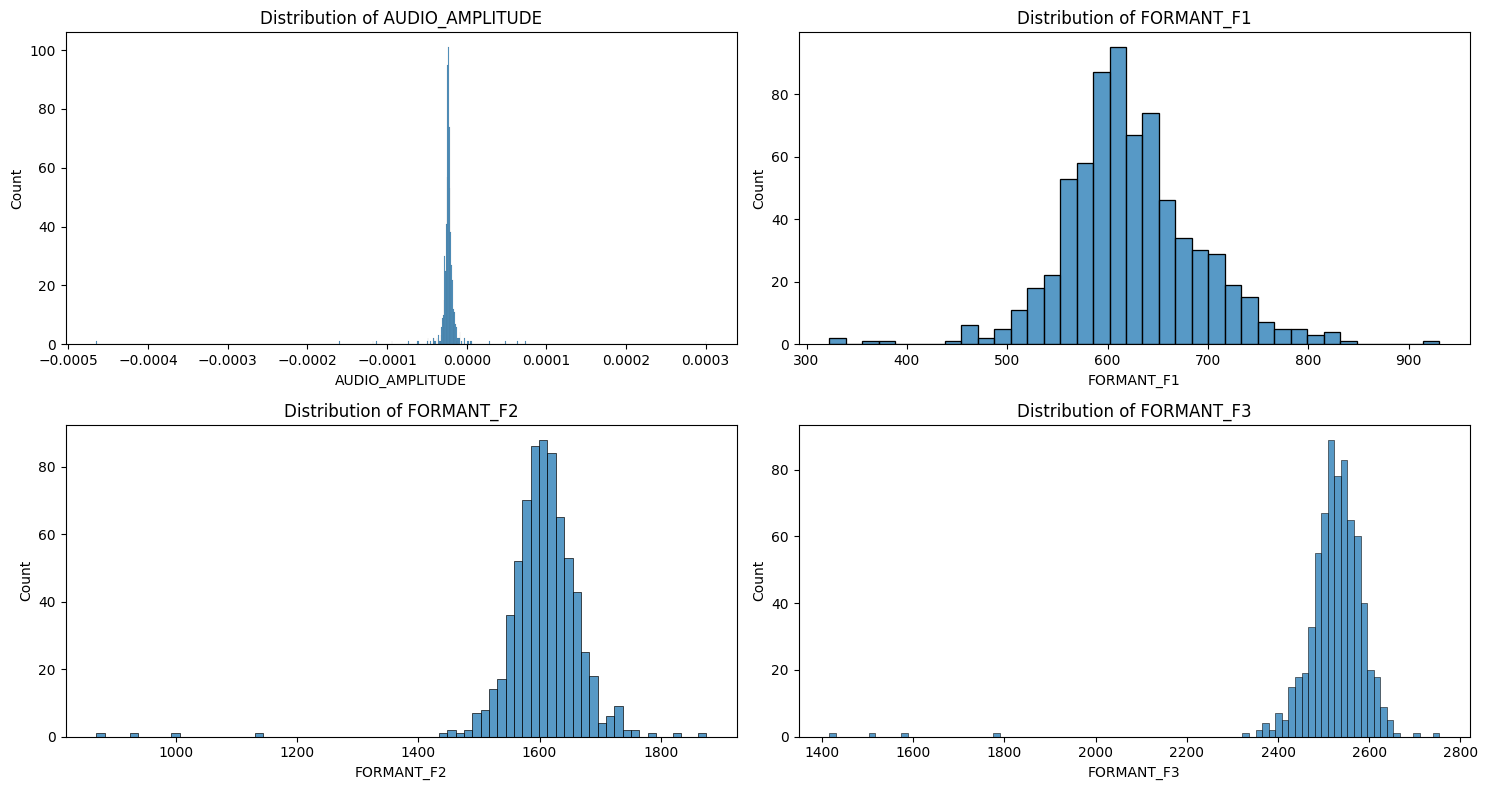

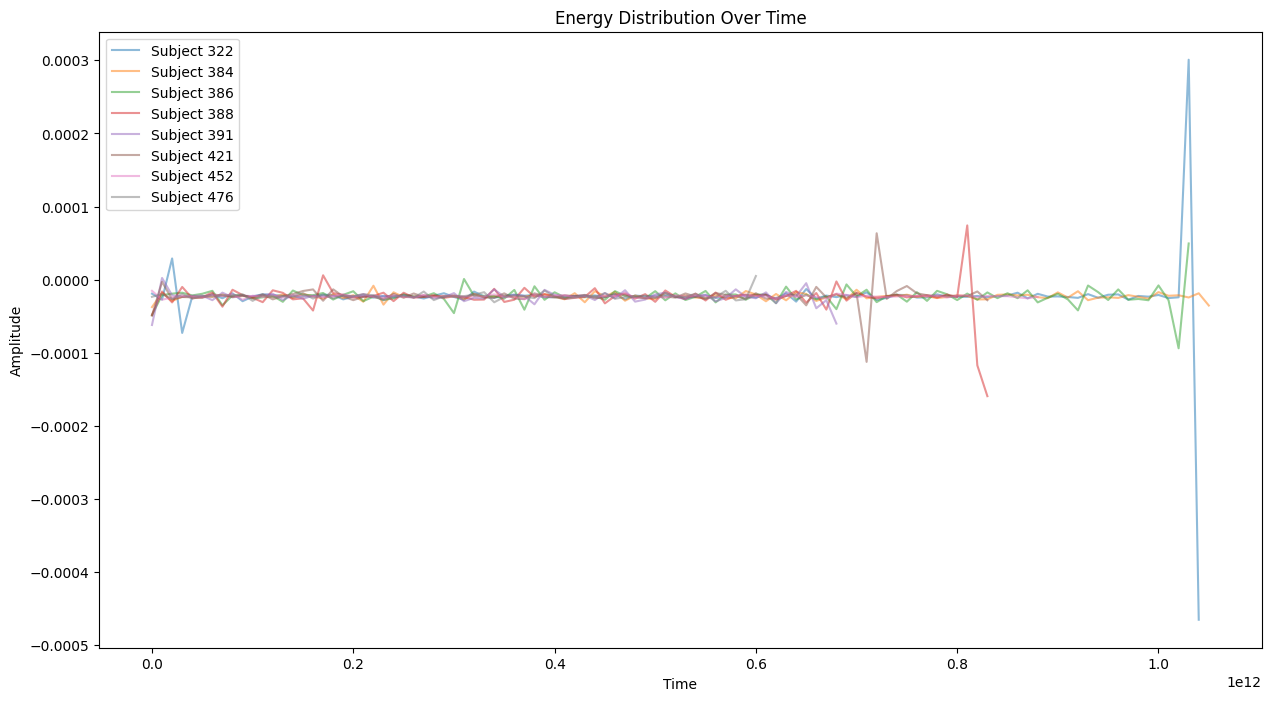

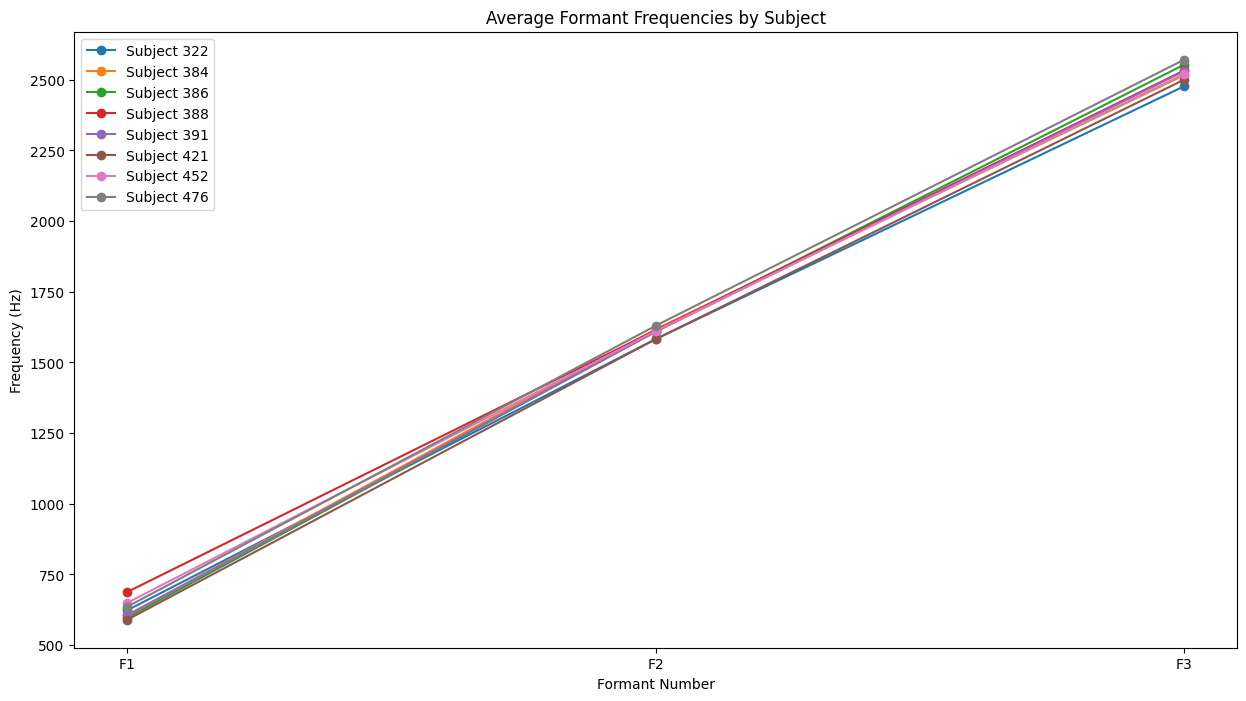

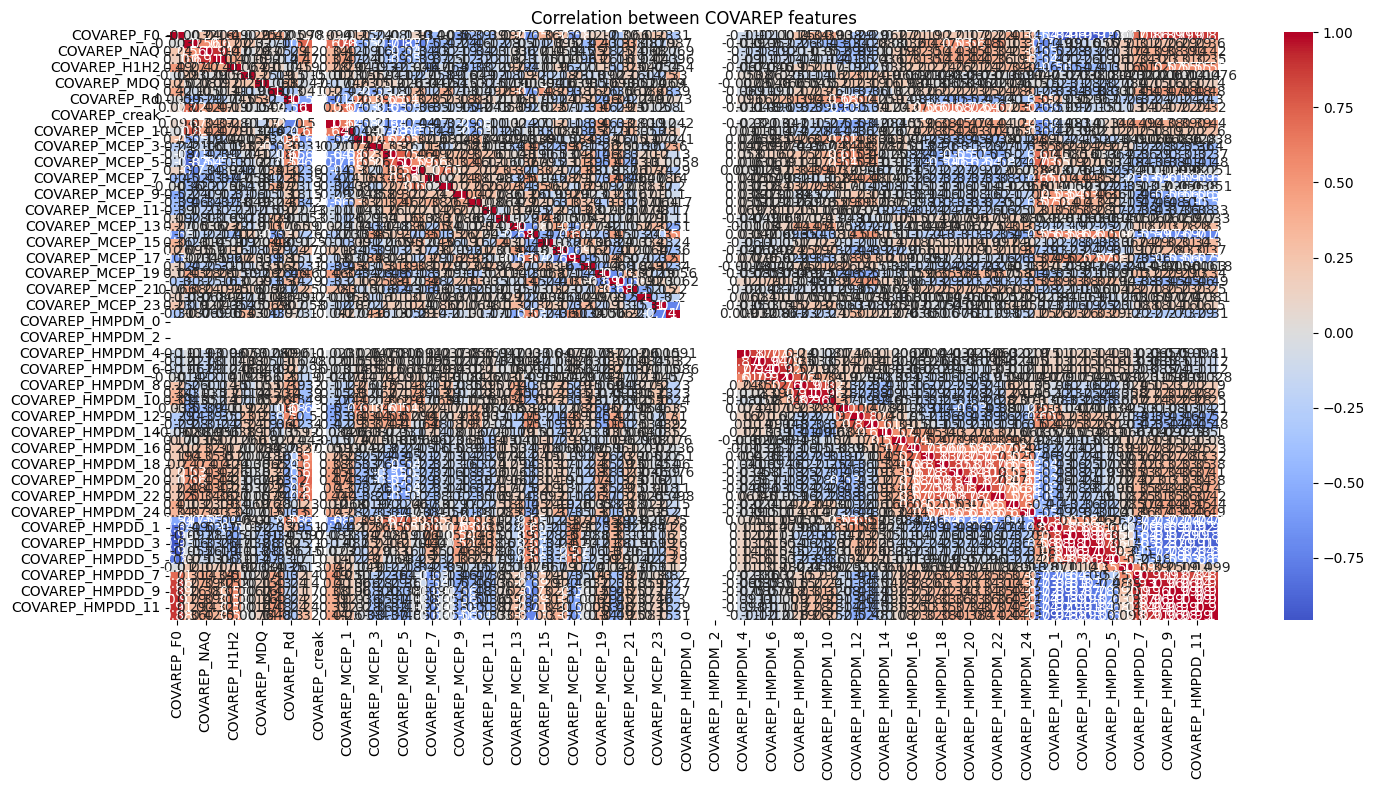

Subject 322 approximate speech activity rate: 0.0381
Subject 384 approximate speech activity rate: 0.0000
Subject 386 approximate speech activity rate: 0.0288
Subject 388 approximate speech activity rate: 0.0476
Subject 391 approximate speech activity rate: 0.0290
Subject 421 approximate speech activity rate: 0.0238
Subject 452 approximate speech activity rate: 0.0000
Subject 476 approximate speech activity rate: 0.0164


In [3]:
def plot_feature_distributions(df: pd.DataFrame, features: List[str], fig_size: Tuple[int, int] = FIGURE_SIZE):
    #Plot distributions of specified features.
    # for plotting distributions of key audio features (provided as a param for flexibility)

    n_features = len(features)
    n_cols = min(2, n_features)
    n_rows = (n_features + 1) // 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size)
    axes = axes.ravel()

    for idx, feature in enumerate(features):
        sns.histplot(data=df[feature], ax=axes[idx])
        axes[idx].set_title(f'Distribution of {feature}')
        axes[idx].set_xlabel(feature)

    plt.tight_layout()
    plt.show()


def plot_energy_distribution(df: pd.DataFrame, fig_size: Tuple[int, int] = FIGURE_SIZE):
    #Plot energy distribution over time for each subject.
    plt.figure(figsize=fig_size)
    for id in df.index.get_level_values('ID').unique():
        plt.plot(df.loc[id]['AUDIO_AMPLITUDE'],
                 alpha=0.5,
                 label=f'Subject {id}')
    plt.title('Energy Distribution Over Time')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()


def plot_formant_frequencies(df: pd.DataFrame, fig_size: Tuple[int, int] = FIGURE_SIZE):
    #Plot average formant frequencies by subject.
    plt.figure(figsize=fig_size)
    formant_features = ['FORMANT_F1', 'FORMANT_F2', 'FORMANT_F3']

    for id in df.index.get_level_values('ID').unique():
        subject_data = df.loc[id][formant_features]
        plt.plot(subject_data.mean(), 'o-', label=f'Subject {id}')

    plt.title('Average Formant Frequencies by Subject')
    plt.xlabel('Formant Number')
    plt.ylabel('Frequency (Hz)')
    plt.xticks([0, 1, 2], ['F1', 'F2', 'F3'])
    plt.legend()
    plt.show()


# Basic statistics
print("Basic statistics for audio features:")
print(df_audio.describe())

# Plot distributions of key audio features
audio_features = ['AUDIO_AMPLITUDE', 'FORMANT_F1', 'FORMANT_F2', 'FORMANT_F3']
plot_feature_distributions(df_audio, audio_features)

# Energy distribution over time
plot_energy_distribution(df_audio)

# Formant frequencies analysis
plot_formant_frequencies(df_audio)

# COVAREP features analysis
covarep_cols = [col for col in df_audio.columns if 'COVAREP' in col]
if covarep_cols:
    plt.figure(figsize=FIGURE_SIZE)
    sns.heatmap(df_audio[covarep_cols].corr(),
                annot=True,
                cmap='coolwarm',
                center=0)
    plt.title('Correlation between COVAREP features')
    plt.tight_layout()
    plt.show()

# Speech rate analysis (using amplitude changes as proxy)
for id in df_audio.index.get_level_values('ID').unique():
    subject_data = df_audio.loc[id]['AUDIO_AMPLITUDE']
    # Calculate zero crossings as a rough measure of speech activity
    zero_crossings = np.where(np.diff(np.signbit(subject_data)))[0]
    speech_rate = len(zero_crossings) / len(subject_data)
    print(f"Subject {id} approximate speech activity rate: {speech_rate:.4f}")


## Principal Component Analysis

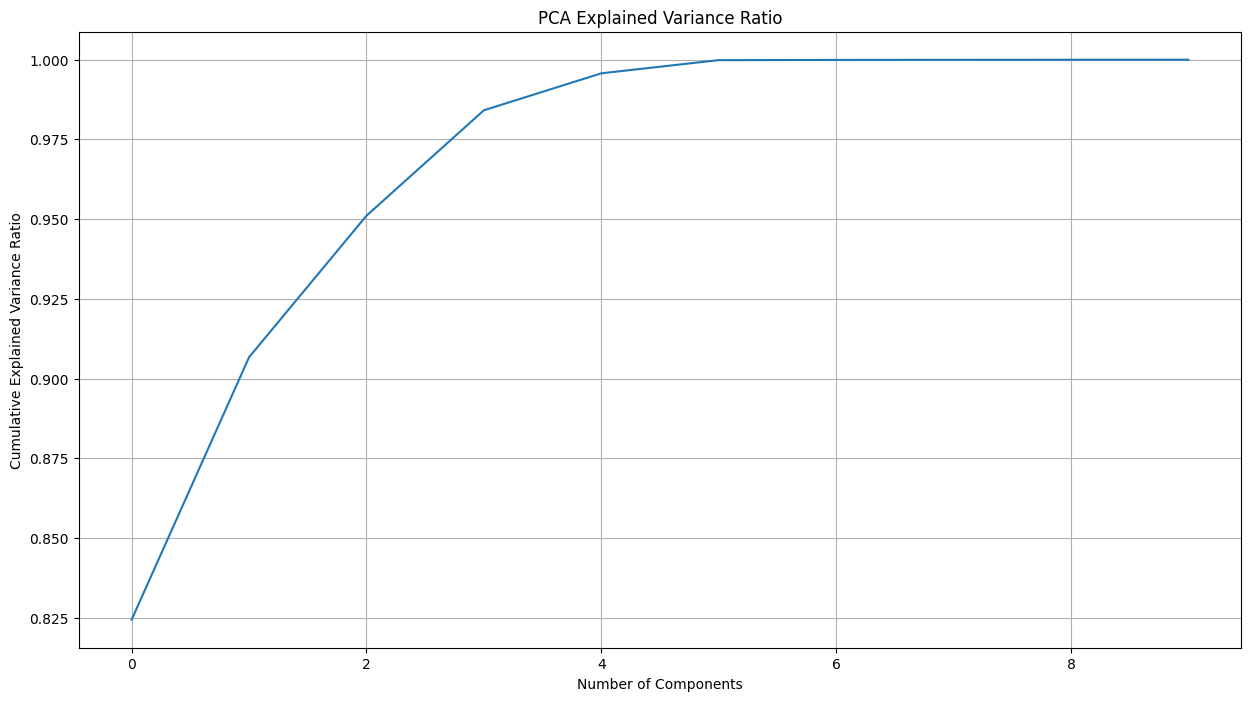

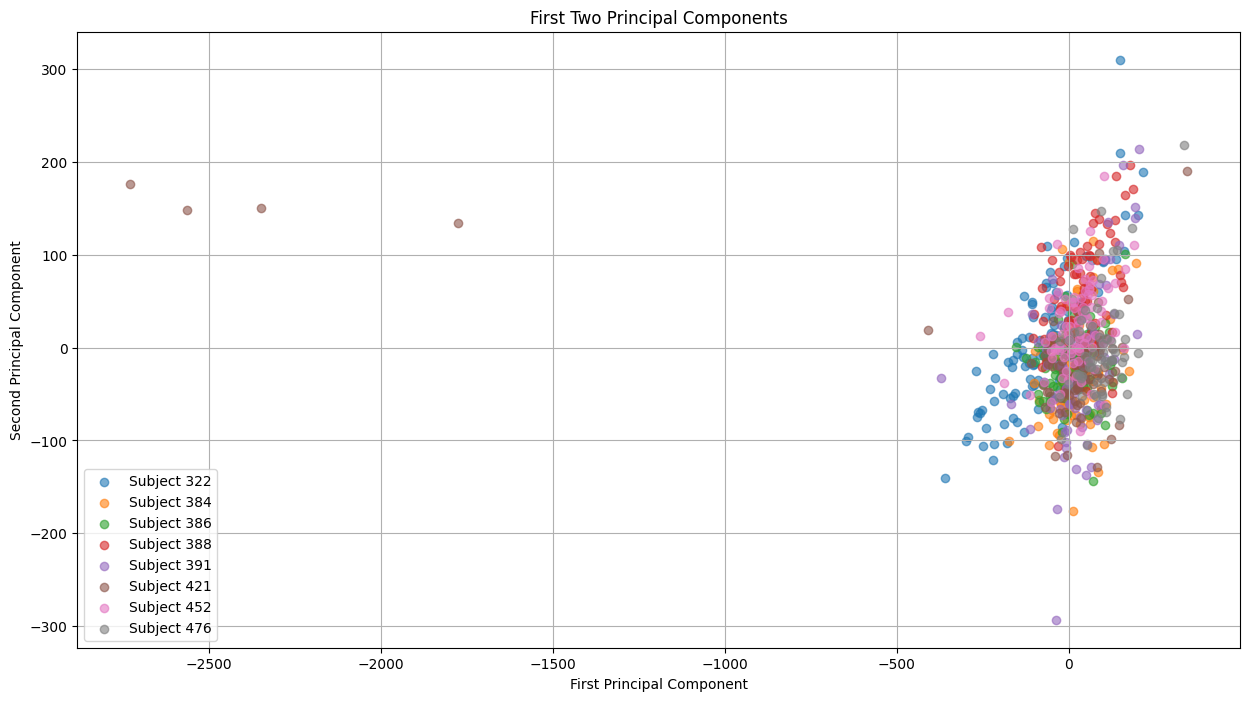


Explained variance ratio for each component:
PC1: 0.8244
PC2: 0.0823
PC3: 0.0444
PC4: 0.0331
PC5: 0.0116
PC6: 0.0041
PC7: 0.0001
PC8: 0.0000
PC9: 0.0000
PC10: 0.0000

Cumulative explained variance ratio:
[0.82436975 0.90667698 0.95106016 0.9841277  0.99571805 0.9998507
 0.99991423 0.99995263 0.99997244 0.99997905]


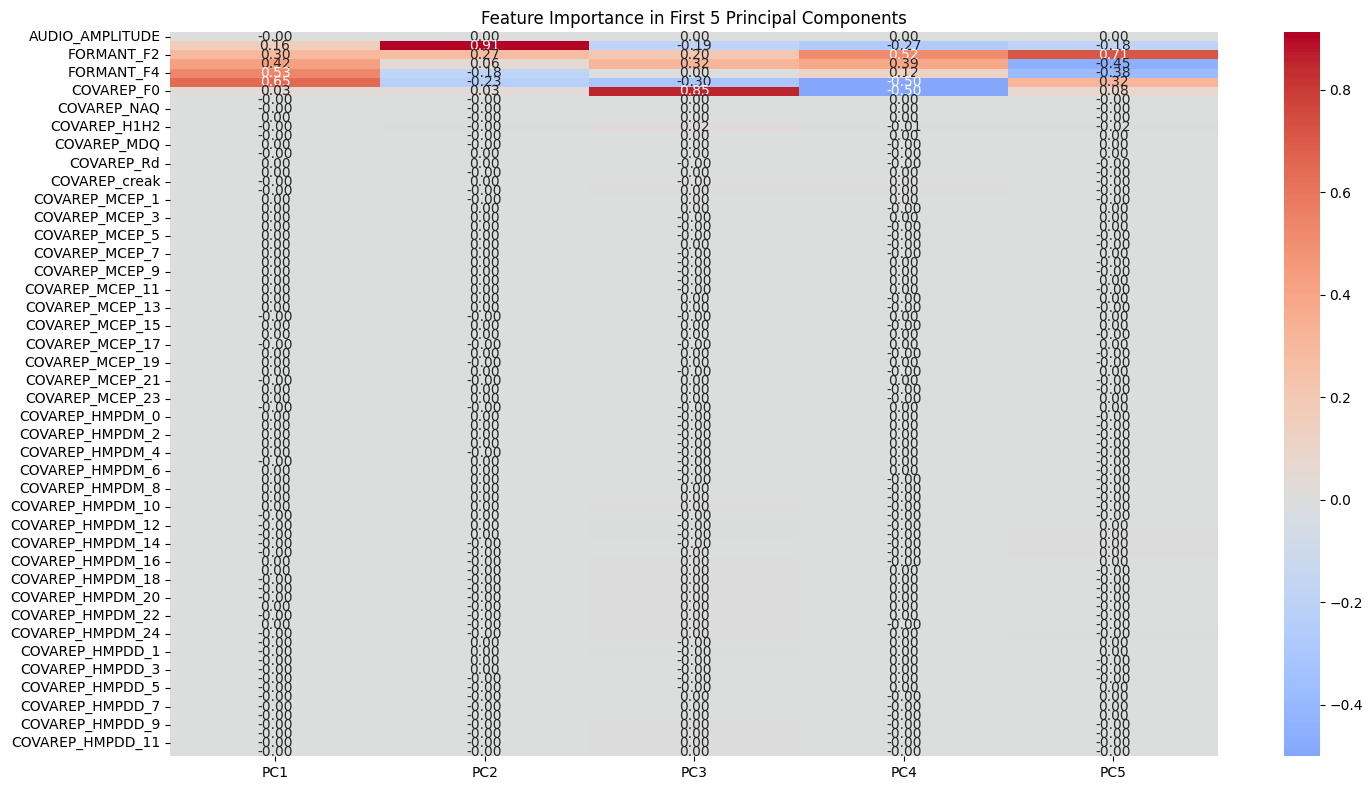

In [4]:
from sklearn.decomposition import PCA
from utils.pca_utils import save_pca_components


def perform_pca(df: pd.DataFrame, n_components: int = 10) -> Tuple[pd.DataFrame, pd.DataFrame, PCA]:
    #Perform PCA on the input data.
    # Select numerical features
    feature_data = df.select_dtypes(include=['float64', 'int64'])

    # Initialize and fit PCA
    pca = PCA(n_components=n_components)  # adjust n_components 
    feature_pca = pca.fit_transform(feature_data)
    
    # Determine the most important features for the first principal component
    abs_loadings = np.abs(pca.components_[0])
    sorted_indices = np.argsort(abs_loadings)[::-1]
    feature_names = [feature_data.columns[i] for i in sorted_indices[:n_components]] 

    # Save PCA components
    save_pca_components(
        pca=pca,
        feature_names=feature_names,
        output_path='models/pca_audio.pkl'
    )
    
    # Create DataFrame with PCA results
    pca_df = pd.DataFrame(
        feature_pca,
        columns=[f'PC{i + 1}' for i in range(feature_pca.shape[1])],
        index=feature_data.index
    )
    
    # Get feature importance
    feature_importance = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i + 1}' for i in range(feature_pca.shape[1])],
        index=feature_data.columns
    )

    return pca_df, feature_importance, pca


# Perform PCA
pca_df, feature_importance, pca = perform_pca(df_audio) # NOTE: by default the PCA will cut it down to 10 features. you can change that by setting n_components

# Plot explained variance ratio
plt.figure(figsize=FIGURE_SIZE)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.grid(True)
plt.show()

# Plot first two principal components
plt.figure(figsize=FIGURE_SIZE)
for id in pca_df.index.get_level_values('ID').unique():
    mask = pca_df.index.get_level_values('ID') == id
    plt.scatter(pca_df[mask]['PC1'],
                pca_df[mask]['PC2'],
                alpha=0.6,
                label=f'Subject {id}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('First Two Principal Components')
plt.legend()
plt.grid(True)
plt.show()

# Print explained variance ratios
print("\nExplained variance ratio for each component:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i + 1}: {ratio:.4f}")

# Print Cumulative explained variance ratio
print("\nCumulative explained variance ratio:")
print(np.cumsum(pca.explained_variance_ratio_))

# Plot heatmap of feature importance for first few components
plt.figure(figsize=FIGURE_SIZE)
sns.heatmap(feature_importance.iloc[:, :5],
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.2f')
plt.title('Feature Importance in First 5 Principal Components')
plt.tight_layout()
plt.show()

## Data Splitting

In [5]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

# def prepare_data_splits(df_audio: pd.DataFrame, df_result: pd.DataFrame) -> Tuple[
#     np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
#     #Prepare data splits for training, validation, and testing.
#     # Merge audio features with depression labels
#     df = pd.merge(df_audio, df_result, on='ID')  

#     # Prepare features and target
#     X = df.drop(['PHQ_Binary'], axis=1)
#     y = df['PHQ_Binary']

#     # Create time series split
#     tscv = TimeSeriesSplit(n_splits=5)
#     train_indices = []
#     test_indices = []

#     # Get split indices while preserving temporal order
#     for train_idx, test_idx in tscv.split(X):
#         train_indices.append(train_idx)
#         test_indices.append(test_idx)

#     # Use the last fold for final train/test split
#     X_train = X.iloc[train_indices[-1]]
#     X_test = X.iloc[test_indices[-1]]
#     y_train = y.iloc[train_indices[-1]]
#     y_test = y.iloc[test_indices[-1]]

#     # Further split training data into train and validation
#     train_size = int(0.75 * len(X_train))
#     X_train, X_val = X_train.iloc[:train_size], X_train.iloc[train_size:]
#     y_train, y_val = y_train.iloc[:train_size], y_train.iloc[train_size:]

#     # Standardize features
#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_val = scaler.transform(X_val)
#     X_test = scaler.transform(X_test)

#     return X_train, X_val, X_test, y_train, y_val, y_test, scaler

def print_split_results(groups, groups_temp, test_idx, train_idx, val_idx, y_test, y_train, y_val):
    print("Split overview:")
    print("-" * 50)
    # Get unique IDs for each split
    train_ids = groups.iloc[train_idx].unique()
    val_ids = groups_temp.iloc[val_idx].unique()
    test_ids = groups_temp.iloc[test_idx].unique()
    print("Sessions in training set:", len(train_ids))
    print(train_ids)
    print("\nSessions in validation set:", len(val_ids))
    print(val_ids)
    print("\nSessions in test set:", len(test_ids))
    print(test_ids)
    print("-" * 50)
    print("Training set:")
    train_dep_ids = groups.iloc[train_idx][y_train == 1].unique()
    train_nondep_ids = groups.iloc[train_idx][y_train == 0].unique()
    total_train_ids = len(train_dep_ids) + len(train_nondep_ids)
    train_dep_pct = (len(train_dep_ids) / total_train_ids) * 100
    print(f"Depressed ({train_dep_pct:.1f}%):")
    print(train_dep_ids)
    print(f"Non-depressed ({100 - train_dep_pct:.1f}%):")
    print(train_nondep_ids)
    print("\nValidation set:")
    val_dep_ids = groups_temp.iloc[val_idx][y_val == 1].unique()
    val_nondep_ids = groups_temp.iloc[val_idx][y_val == 0].unique()
    total_val_ids = len(val_dep_ids) + len(val_nondep_ids)
    val_dep_pct = (len(val_dep_ids) / total_val_ids) * 100
    print(f"Depressed ({val_dep_pct:.1f}%):")
    print(val_dep_ids)
    print(f"Non-depressed ({100 - val_dep_pct:.1f}%):")
    print(val_nondep_ids)
    print("\nTest set:")
    test_dep_ids = groups_temp.iloc[test_idx][y_test == 1].unique()
    test_nondep_ids = groups_temp.iloc[test_idx][y_test == 0].unique()
    total_test_ids = len(test_dep_ids) + len(test_nondep_ids)
    test_dep_pct = (len(test_dep_ids) / total_test_ids) * 100
    print(f"Depressed ({test_dep_pct:.1f}%):")
    print(test_dep_ids)
    print(f"Non-depressed ({100 - test_dep_pct:.1f}%):")
    print(test_nondep_ids)
    print("-" * 50)

def check_temporal_consistency(X_train, X_val, X_test, df):
    for session_id in df['ID'].unique():
        session_times = df[df['ID'] == session_id]['TIMESTAMP']
        if len(session_times) > 1:
            time_diff = session_times.diff().dropna()
            if (time_diff < pd.Timedelta(0)).any():
                print(f"Warning: Temporal inconsistency detected in session {session_id}")


def prepare_data_splits(df_audio: pd.DataFrame, df_result: pd.DataFrame) -> Tuple[
    np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, StandardScaler]:
    
    # Reset index of df_result to make 'ID' a column
    df_result = df_result.reset_index()
    df_audio = df_audio.reset_index()

    # Merge audio features with depression labels
    df = pd.merge(df_audio, df_result, on='ID')

    # Sort by ID and timestamp to maintain temporal ordering within sessions (probably not needed but just in case)
    df = df.sort_values(['ID', 'TIMESTAMP'])
    
    # Prepare features and target
    X = df.drop(['PHQ_Binary', 'ID', 'TIMESTAMP'], axis=1)  # Drop ID and TIMESTAMP as they're not features NOTE: do we really need to drop them?
    y = df['PHQ_Binary']
    groups = df['ID']  # Use ID as the grouping variable
    
    # First split: 60% train, 40% temp (which will be split into val and test)
    gss_train = GroupShuffleSplit(n_splits=1, train_size=0.6, random_state=42)
    train_idx, temp_idx = next(gss_train.split(X, y, groups))
    
    # Get the temporary set
    X_temp = X.iloc[temp_idx]
    y_temp = y.iloc[temp_idx]
    groups_temp = groups.iloc[temp_idx]
    
    # Second split: Split the remaining 40% into validation and test (50-50 split, which gives us 20-20 of original)
    gss_val = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=42)
    val_idx, test_idx = next(gss_val.split(X_temp, y_temp, groups_temp))
    
    # Get the final splits
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_val = X_temp.iloc[val_idx]
    y_val = y_temp.iloc[val_idx]
    X_test = X_temp.iloc[test_idx]
    y_test = y_temp.iloc[test_idx]
    
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Check for temporal consistency
    check_temporal_consistency(X_train, X_val, X_test, df)

    # Print split results
    print_split_results(groups, groups_temp, test_idx, train_idx, val_idx, y_test, y_train, y_val)

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler


# Prepare data splits
X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_data_splits(pca_df, df_result)



Split overview:
--------------------------------------------------
Sessions in training set: 4
[386 388 391 452]

Sessions in validation set: 2
[322 421]

Sessions in test set: 2
[384 476]
--------------------------------------------------
Training set:
Depressed (50.0%):
[386 388]
Non-depressed (50.0%):
[391 452]

Validation set:
Depressed (50.0%):
[421]
Non-depressed (50.0%):
[322]

Test set:
Depressed (50.0%):
[384]
Non-depressed (50.0%):
[476]
--------------------------------------------------


## Model Training

100%|██████████| 8/8 [00:24<00:00,  3.03s/it]


Epoch 16/50
Train Loss: 0.4087, Val Loss: 1.2834, LR: 0.000250
Early stopping triggered at epoch 16

Best parameters:
dropout: 0.3
hidden_size: 32
learning_rate: 0.0005
num_layers: 1


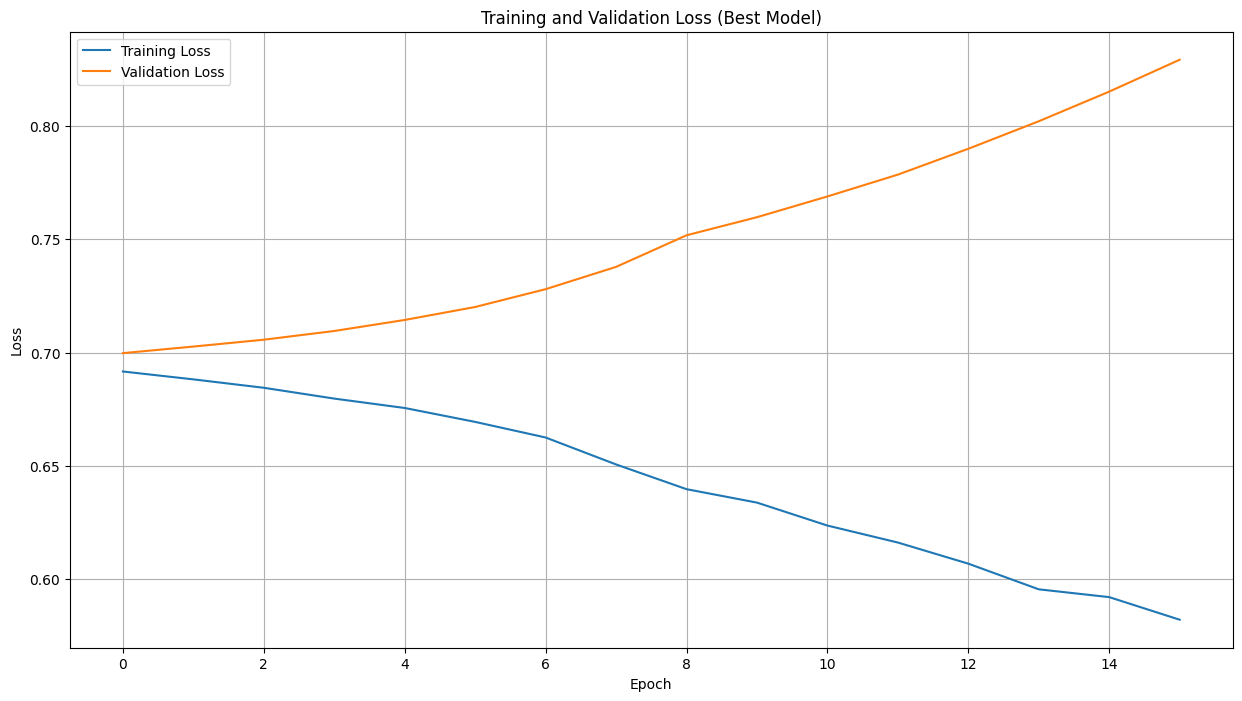

In [6]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from training.trainer import save_model


def create_data_loaders(X_train: np.ndarray, X_val: np.ndarray, X_test: np.ndarray,
                        y_train: np.ndarray, y_val: np.ndarray, y_test: np.ndarray,
                        batch_size: int = BATCH_SIZE) -> Tuple[DataLoader, DataLoader, DataLoader]:
    #Create PyTorch DataLoaders for training, validation, and testing.
    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)
    X_test_tensor = torch.FloatTensor(X_test)
    y_train_tensor = torch.LongTensor(y_train.values)
    y_val_tensor = torch.LongTensor(y_val.values)
    y_test_tensor = torch.LongTensor(y_test.values)

    # Create datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader


def train_model_with_grid_search(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray,
                                 param_grid: Dict, n_epochs: int = N_EPOCHS) -> Tuple[Dict, List[Dict]]:
    #Perform grid search to find optimal hyperparameters.
    # Create data loaders
    train_loader, val_loader, _ = create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test)

    # Initialize tracking variables
    best_val_loss = float('inf')
    best_params = None
    best_model_state = None
    results = []

    # Grid search
    for params in tqdm(ParameterGrid(param_grid)):
        # Model initialization
        model = AudioRNN(
            input_size=X_train.shape[1],
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            dropout=params['dropout']
        ).to(DEVICE)

        # Training setup
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=7,
            verbose=True,
            min_lr=1e-6
        )

        # Initialize trainer
        trainer = AudioRNNTrainer(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            device=DEVICE,
            early_stopping_patience=15
        )

        # Train model
        train_losses, val_losses = trainer.train(
            train_loader=train_loader,
            val_loader=val_loader,
            n_epochs=n_epochs
        )

        # Record results
        final_val_loss = val_losses[-1]
        results.append({
            'params': params,
            'final_val_loss': final_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses
        })

        # Update best parameters
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_params = params
            best_model_state = model.state_dict()
        
            # Save the best model using the save_model function
            save_model(
                model=model,
                scaler=scaler,
                input_size=X_train.shape[1],
                best_params=params,
                save_path='checkpoints/audio_best_model.pth'
            )

    return best_params, results


# Train model with grid search
best_params, results = train_model_with_grid_search(X_train, y_train, X_val, y_val, PARAM_GRID) # TODO: set num of epochs as well

# Print best parameters
print("\nBest parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
# print(f"Best validation loss: {best_val_loss:.4f}")

# Plot training curves for best model
plt.figure(figsize=FIGURE_SIZE)
best_result = min(results, key=lambda x: x['final_val_loss'])
plt.plot(best_result['train_losses'], label='Training Loss')
plt.plot(best_result['val_losses'], label='Validation Loss')
plt.title('Training and Validation Loss (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Model Evaluation


Prediction Statistics:
Mean probability for class 0: 0.418
Mean probability for class 1: 0.582
Number of predictions for class 0: 7
Number of predictions for class 1: 160

Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.02      0.03        61
           1       0.62      0.94      0.75       106

    accuracy                           0.60       167
   macro avg       0.38      0.48      0.39       167
weighted avg       0.45      0.60      0.49       167



<Figure size 1500x800 with 0 Axes>

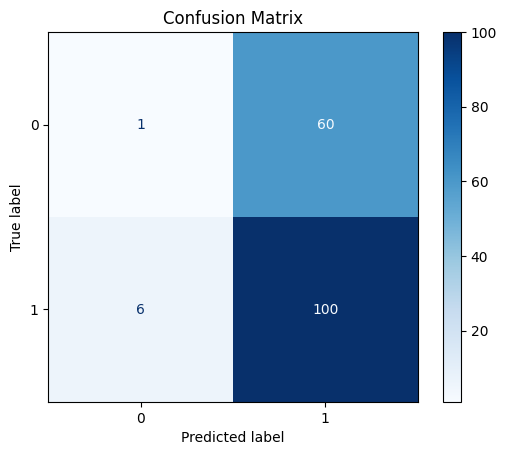

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# def evaluate_model(model: nn.Module, test_loader: DataLoader, device: torch.device) -> Tuple[np.ndarray, np.ndarray]:
#     #Evaluate the model on the test set.
#     model.eval()
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for X, y in test_loader:
#             X, y = X.to(device), y.to(device)
#             outputs = model(X)
#             _, preds = torch.max(outputs, 1)
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(y.cpu().numpy())

#     return np.array(all_labels), np.array(all_preds)


# # Create test loader
# _, _, test_loader = create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test)

# # Initialize best model
# best_model = AudioRNN(
#     input_size=X_train.shape[1],
#     hidden_size=best_params['hidden_size'],
#     num_layers=best_params['num_layers'],
#     dropout=best_params['dropout']
# ).to(DEVICE)

# # Evaluate model
# y_true, y_pred = evaluate_model(best_model, test_loader, DEVICE)

# # Print classification report
# print("Classification Report:")
# print(classification_report(y_true, y_pred))

# # Plot confusion matrix
# plt.figure(figsize=FIGURE_SIZE)
# class_labels = [0, 1]
# cm = confusion_matrix(y_true, y_pred, labels=class_labels)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
# disp.plot(cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.show()

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from training.trainer import load_model  # Add this import at the top of your notebook

def evaluate_model(model: nn.Module, test_loader: DataLoader, device: torch.device) -> Tuple[np.ndarray, np.ndarray]:
    """Evaluate the model on the test set."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Print prediction statistics
    probs_array = np.array(all_probs)
    print("\nPrediction Statistics:")
    print(f"Mean probability for class 0: {probs_array[:, 0].mean():.3f}")
    print(f"Mean probability for class 1: {probs_array[:, 1].mean():.3f}")
    print(f"Number of predictions for class 0: {(np.array(all_preds) == 0).sum()}")
    print(f"Number of predictions for class 1: {(np.array(all_preds) == 1).sum()}")

    return np.array(all_labels), np.array(all_preds)

# Create test loader
_, _, test_loader = create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test)

# Load the best model using the load_model function
best_model, _ = load_model(
    model_class=AudioRNN,
    load_path='checkpoints/audio_best_model.pth',
    device=DEVICE
)

# Make sure the model is in eval mode
best_model.eval()

# Evaluate model
y_true, y_pred = evaluate_model(best_model, test_loader, DEVICE)

# Print classification report with zero_division=1 to avoid warnings
print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=1))

# Plot confusion matrix
plt.figure(figsize=FIGURE_SIZE)
class_labels = [0, 1]
cm = confusion_matrix(y_true, y_pred, labels=class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


## Save Model

In [8]:
from training.trainer import save_model

# Save the model and scaler
save_model(best_model, scaler, X_train.shape[1], best_params, "audio_model.pth")
print("Model and scaler saved successfully!")

Model and scaler saved successfully!
